### Transfer Learning VGG16 avec augmentation et recadrage 256x256

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model, Sequential

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.applications.vgg16 import VGG16
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data_detour = pd.read_csv('../files_detour_256.csv',index_col=0)

In [4]:
# Garde seulement les images où le détourage possible pour comparaison avec/sans détourage
data = data[data['filename'].isin(data_detour['filename'])]

In [5]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

#### Utilisation d'un ImageDataGenerator

In [9]:
# Recadrage de l'image
def preprocess(img):
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Preprocess de EfficientNet
    return img

In [10]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess,horizontal_flip=True, vertical_flip=True,
                                    rotation_range=180
                                                       )
test_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [11]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

Found 25596 validated image filenames belonging to 10 classes.
Found 2845 validated image filenames belonging to 10 classes.


#### Transfer Learning avec modèle VGG16
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Sans Dropout
* Compilation avec Adam avec learning_rate de 10-4

In [12]:
# Création Callback pour stopper si stagnation
cb_earlystop = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
cb_checkpoint= ModelCheckpoint(
    filepath='./vgg16_10_weights_augm',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
# Création d'un modèle MobileNet
def model_VGG16():
    base_model = VGG16(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model_VGG16()

In [15]:
#Recharge poids suite à plantage
model.load_weights("vgg16_10_weights_augm")

In [18]:
#Entrainement par 5 epochs puis relancer pour pb plantage python
history = model.fit(data_train_generator, epochs = 5, validation_data = data_test_generator,callbacks=[cb_earlystop,cb_checkpoint])

Epoch 1/5
800/800 [==============================] - 10986s 14s/step - loss: 0.5636 - accuracy: 0.8130 - val_loss: 0.5016 - val_accuracy: 0.8267
Epoch 2/5
800/800 [==============================] - 10033s 13s/step - loss: 0.5496 - accuracy: 0.8143 - val_loss: 0.5065 - val_accuracy: 0.8292
Epoch 3/5
800/800 [==============================] - 10036s 13s/step - loss: 0.5379 - accuracy: 0.8227 - val_loss: 0.5048 - val_accuracy: 0.8320
Epoch 4/5
800/800 [==============================] - 10063s 13s/step - loss: 0.5248 - accuracy: 0.8249 - val_loss: 0.5120 - val_accuracy: 0.8323


In [19]:
model.save_weights("vgg16_10_weights_augm")

#### Prédiction sur les données d'évaluation

In [ ]:
# model = model_VGG16()
# model.load_weights("vgg16_10_weights_augm")

In [22]:
data_eval_generator = test_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32,shuffle=False)

Found 3161 validated image filenames belonging to 10 classes.


In [21]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 1079s 11s/step - loss: 0.5118 - accuracy: 0.8330


[0.5117564797401428, 0.8329642415046692]

 * Score plus faible de 2% qu'un LeNet

#### Fine Tunning

In [29]:
model = model_VGG16()
model.load_weights("vgg16_10_weights_augm")

In [30]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [16]:
# Unfreeze 2 derniers blocs du modèle de base : block4, block5
for layer in model.layers[-16:]:
    layer.trainable = True

In [18]:
model.compile(optimizer=SGD(learning_rate=1e-4,momentum=0.9) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
cb_earlystop = EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)
cb_reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

In [25]:
model.load_weights("vgg16_10_weights_augm")

In [24]:
history = model.fit(data_train_generator, epochs = 5, validation_data = data_test_generator,callbacks=[cb_reducelr,cb_earlystop,cb_checkpoint])

Epoch 1/5
800/800 [==============================] - 17376s 22s/step - loss: 0.2222 - accuracy: 0.9281 - val_loss: 0.2320 - val_accuracy: 0.9234
Epoch 2/5
800/800 [==============================] - 17379s 22s/step - loss: 0.2150 - accuracy: 0.9303 - val_loss: 0.2505 - val_accuracy: 0.9178
Epoch 3/5
800/800 [==============================] - 18134s 23s/step - loss: 0.2106 - accuracy: 0.9323 - val_loss: 0.2398 - val_accuracy: 0.9220
Epoch 4/5
800/800 [==============================] - 18710s 23s/step - loss: 0.1879 - accuracy: 0.9398 - val_loss: 0.2247 - val_accuracy: 0.9262
Epoch 5/5
800/800 [==============================] - 17931s 22s/step - loss: 0.1829 - accuracy: 0.9402 - val_loss: 0.2278 - val_accuracy: 0.9241


In [34]:
model.save_weights("vgg16_10_weights_augm")

#### Evaluation des résultats

In [26]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 1189s 12s/step - loss: 0.2316 - accuracy: 0.9244


[0.23156777024269104, 0.9243910312652588]

In [27]:
#Classes prédites
predict = model.predict(data_eval_generator)

In [28]:
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.95      0.97      0.96       118
       blast       0.84      0.87      0.86       325
  eosinophil       1.00      0.98      0.99       320
erythroblast       0.95      0.94      0.95       217
          ig       0.88      0.82      0.85       386
  lymphocyte       0.95      0.93      0.94       467
    monocyte       0.91      0.89      0.90       264
  neutrophil       0.97      0.98      0.98       580
    platelet       1.00      1.00      1.00       231
      smudge       0.78      0.89      0.83       253

    accuracy                           0.92      3161
   macro avg       0.92      0.93      0.92      3161
weighted avg       0.93      0.92      0.92      3161



> +1.5% par rapport à EfficientNet

In [29]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,114,0,1,0,3,0,0,0,0,0
blast,0,284,0,0,13,6,12,0,0,10
eosinophil,0,0,313,0,0,0,0,3,0,4
erythroblast,0,0,0,204,3,6,2,0,0,2
ig,5,27,0,4,317,3,8,8,0,14
lymphocyte,0,7,0,5,1,435,1,1,0,17
monocyte,0,10,0,0,5,2,234,1,0,12
neutrophil,1,1,0,0,7,2,0,566,0,3
platelet,0,0,0,1,0,0,0,0,230,0


> Confusion importante blaste/IG ainsi que monocyte/IG

In [30]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [31]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

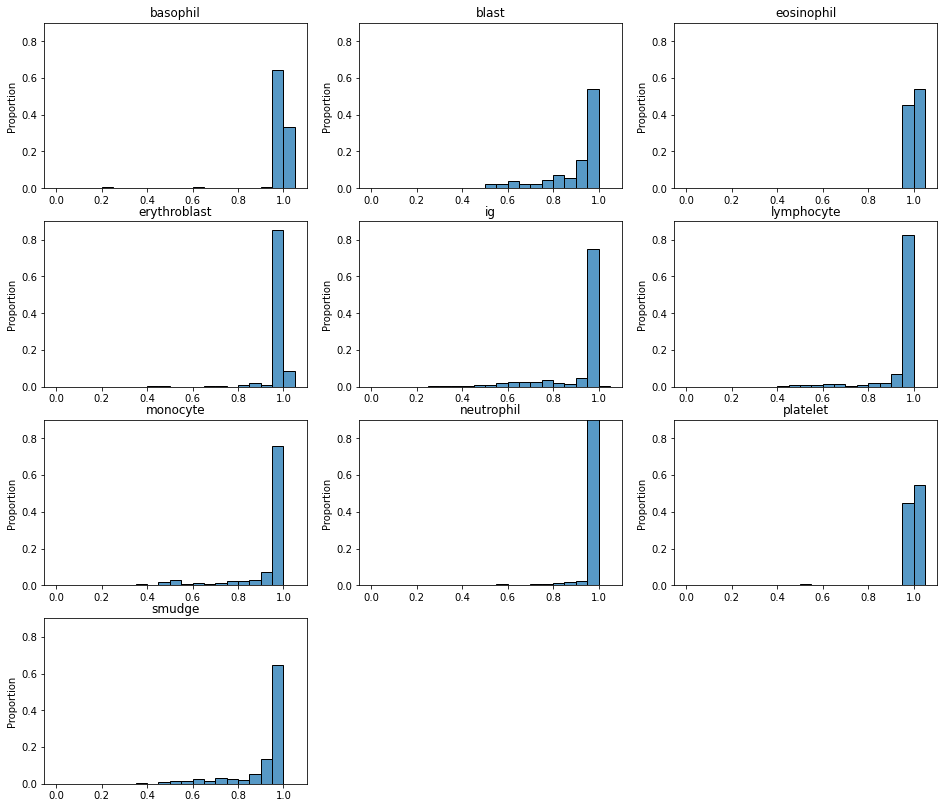

In [32]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [33]:
import gradcam_dataset

In [34]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [35]:
img_size = (256, 256)
last_conv_layer_name = "block5_conv3"

In [36]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

##### BASOPHIL

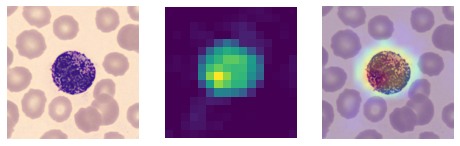

In [37]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

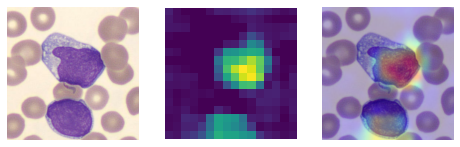

In [38]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

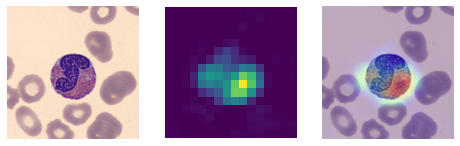

In [39]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

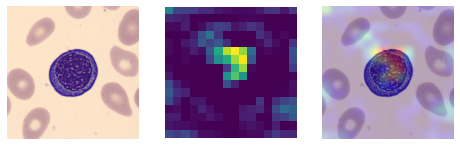

In [40]:
path = data[data['filename']=='ERB_7315.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

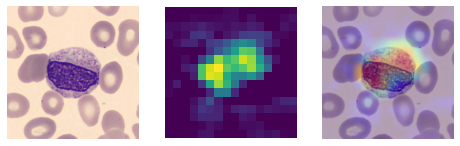

In [41]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

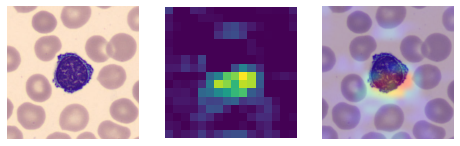

In [42]:
path = data[data['filename']=='LY_32523.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

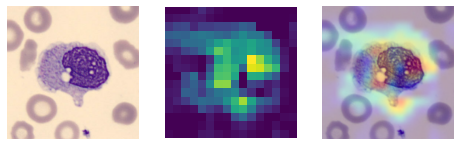

In [43]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

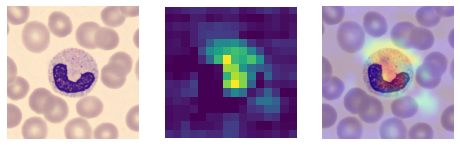

In [44]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

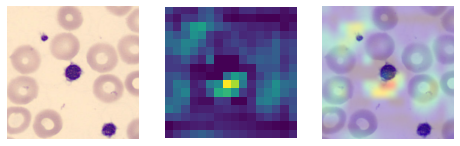

In [45]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

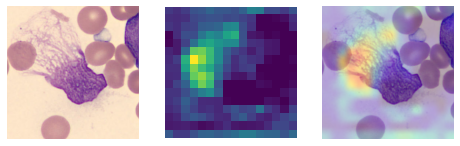

In [46]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)